# Initial introduction
This notebook is an initial introduction to the data we will be working with during the mini project

## Useful imports

In [180]:
import hyperspy.api as hs                 # hyperspectral data processing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps

# For non-interactive plots
# %matplotlib inline     

# For interactive plots
%matplotlib qt         

# Seems can ignore warnings

## Load data and see what we have
Start by collecting the relevant filepaths - we'll focus on example 1 in this notebook

In [181]:
'On my work PC'
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'

'Applicable to Olympus PC'
# Example 1 contains image time series during 90 C growth
#folder = r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 1 reflection growth\2 reflection\\'

# Example 2 contains hyperspectral time series data for 60 C growth
#folder = r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\'

# Automatically get all filepaths in example folder
fpaths = []
_, _, fnames = next(walk(folder)) # ignores other outputs of this
for fname in fnames:
    fpaths.append(folder+fname)

# Automatically place into numerical order rather than 1, 10, 11
fpaths = natsorted(fpaths)

#fpaths
len(fpaths)

111

.h5 files have a hierarchical 'folder-like' structure where we can access inidividual files using keys. Beyond this, each 'folder' can be assigned attributes to store relevant metadata. Let's see what keys we have in this dataset.

In [182]:
fpaths[2]

'C:\\Users\\es758\\Documents\\Python Scripts\\Mini 1\\Reflection data subset\\\\Untitled_2.h5'

In [183]:
# Load a single file to look at
f = h5py.File(fpaths[2],'r')

# First start by finding the 'keys' (i.e. folder headings)
def allkeys(obj):
    "Recursively find all keys in an h5py.Group."
    keys = (obj.name,)
    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + allkeys(value)
            else:
                keys = keys + (value.name,)
    return keys

keys = allkeys(f)

# Now let's check each folder for any attributes and print them all out
for key in keys:
    print(key)
    attrs = list(f[key].attrs.keys())
    if attrs != []:
        print('\t',attrs)
    #print('\n')

/
/Cube
/Cube/Angle
/Cube/Images
/Cube/Info
/Cube/Info/Camera
	 ['AveragingMode', 'Binning', 'BitDepth', 'CaptorSize', 'CoolerSetPoint', 'DetectorMode', 'GradientOrientation', 'Model', 'Name', 'Orientation', 'PixelSizeNm', 'ReadoutSpeed', 'RoiSize', 'RoiStart', 'SN', 'Shutter', 'Temperature', 'Trigger', 'VerticalFlip']
/Cube/Info/Camera/DynamicProperties
	 ['ROI Mode']
/Cube/Info/Camera/XAxis
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/XAxis/0
	 ['Name']
/Cube/Info/Camera/XAxis/1
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/YAxis
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/YAxis/0
	 ['Name']
/Cube/Info/Camera/YAxis/1
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Cube
	 ['AcqMode', 'BroadBand', 'CreationDate', 'LaserNm', 'Name', 'Type']
/Cube/Info/Cube/ZAxis
	 ['Key']
/Cube/Info/Grating
/Cube/Info/Grating/0
	 ['BeamSide', 'FWHM', 'MaxWavelength', 'MinWavelength', 'Name', 'Type']
/Cube/Info/Grating/0/Calibration
	 ['Curve', 'Factor', 'FocalLe

In [184]:
list(f["Cube/Timestamp"])


[b'2021/04/14 14:19:04.599']

Let's have a look at some relevant ones - namely images and timestamp

In [ ]:
# In example 2 we can also look at wavelengths
wls = f['Cube/Wavelength']
plt.plot(wls,'o-')
plt.xlabel('Index',fontsize = 15)
plt.ylabel('Wavelength / nm',fontsize = 15)
min(wls),max(wls)

KeyError: "Unable to open object (object 'Wavelength' doesn't exist)"

Let's try to extract the time associated with each frame

In [185]:
# Here we will extract the time associated with each frame from the timestamp data
ts = []
tstamps = []
for i,fpath in enumerate(fpaths):
    # Load file
    f = h5py.File(fpath,'r')
    # Access timestamp
    tstamp = list(f['Cube/Timestamp'])[0].astype(str)
    # Remove the date and keep the time
    tstamp = tstamp.split(sep=' ')[1]
    tstamps.append(tstamp)
    # Load tstamp string into correct datetime format
    t0 = datetime.strptime(tstamps[0], "%H:%M:%S.%f")
    t1 = datetime.strptime(tstamps[i], "%H:%M:%S.%f")
    # Calculate difference between current frame and initial frame in seconds
    diff = t1-t0
    t = diff.total_seconds()
    # append result
    ts.append(t)

Text(0, 0.5, 'Time / s')

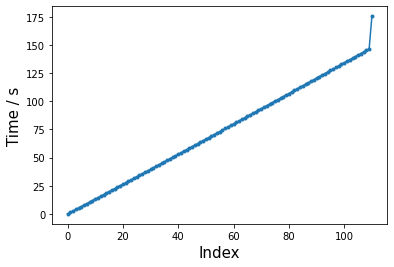

In [186]:
%matplotlib inline

# Let's have a look at the times
plt.plot(ts,'.-')
plt.xlabel('Index', fontsize=15)
plt.ylabel('Time / s', fontsize=15)

clearly past i = 109 we are looking at different data...

In [134]:
ts[109],ts[110]

(146.448, 175.397)

Now let's actually look at the images

In [187]:
images = []
for i,fpath in enumerate(fpaths):
    # Load file
    f = h5py.File(fpath,'r')
    # Extract the image
    image = f['Cube/Images'][0]
    images.append(image)
print(type(images[0]))
print(type(images[0][0][0]))

    
# Convert format for wider compatibility   
images = np.array(images).astype('float32') # float32 is just data type change of the intensities I guess. better for hyperspy and other stuff
print(type(images[0]))
print(type(images[0][0][0]))
print(type(images[0,0,0])) # equivalent for np array index
np.shape(images) #number, pixel, pixel

<class 'numpy.ndarray'>
<class 'numpy.uint16'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>
<class 'numpy.float32'>


(111, 1024, 1024)

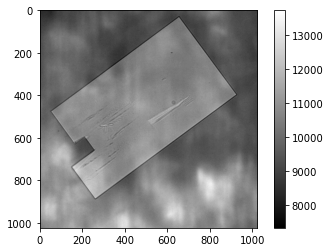

In [136]:
# Let's plot a specific image
%matplotlib inline
plt.imshow(images[1],cmap='gray')
plt.colorbar()

In [188]:
# We can also load the images into hyperspy which makes it easy for us to look at the whole series
%matplotlib qt
s = hs.signals.Signal2D(images)
s.plot()

Let's see if we can also extract the resolution

In [189]:
scale = f['Cube/Info/Camera'].attrs['PixelSizeNm'][0] #in nm/pixel, this is the camera pixel size, not the image pixel size!!
magnification = int(f['Cube/Info/Optics'].attrs['Objective'][0][:-1]) # need to strip 'x' symbol at end

pixel_size = scale/(1000*magnification) # this is the image pixel calibration in um/px

print(r'Our image has %.3f pixels per um' % pixel_size)

Our image has 0.325 pixels per um


So let's replot an image, scaled, at a specific time, without the additional data past i=281

In [190]:
# crop out last few frames
images = images[:109]
ts = ts[:109]

# Figure out max extent of image for scaling
im_shape= np.array(np.shape(images[0]))
im_length = im_shape*pixel_size
print(im_length)

%matplotlib qt
i = 0 # choose frame to plot
plt.imshow(images[i],cmap='gray',extent=[0,im_length[0],0,im_length[1]],vmin=np.min(images),vmax=np.max(images))
plt.colorbar()
plt.xlabel(r'$x / \mu m$', fontsize=15)
plt.ylabel(r'$y / \mu m$', fontsize=15)
plt.title('t = %.2f s' % ts[i])

[332.8 332.8]


Text(0.5, 1.0, 't = 0.00 s')

In [35]:
images[0][0,0] # extracting a pixel in a way that seems sane to me.

8513.0

Okay, so we can see this dataset consists of 281 1024x1024 images recorded in a reflection microscope setup to a resolution of .325 px/um, and shows a perovskite single crystal growing at 90 C over a period of 6.5 minutes.

# Now let's try to do some quantification


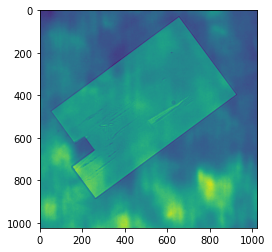

In [191]:
im = images[0]
%matplotlib inline
plt.imshow(im)

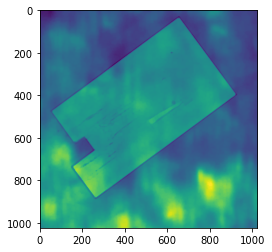

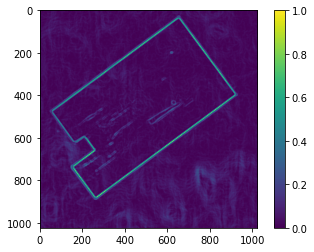

In [142]:
# I thinik this is setting the size of a kernel
k_blur = 9 
k_open = 9
k_sobel=15

# Blur image
blurred = cv2.GaussianBlur(im, (k_blur, k_blur), 0)

# Open image
kernel = np.ones((k_open,k_open),np.uint8)
opening = cv2.morphologyEx(blurred,cv2.MORPH_OPEN,kernel)

plt.imshow(opening)
plt.show()

# Sobel filter
# Basically finds strong gradients going both ways for each pixel and adds them to come up with a sort of approximate
# Isn't quite contours yet but is making what should be contours stand out.
sobelx = cv2.Sobel(opening,cv2.CV_64F,1,0,ksize=k_sobel)
sobely = cv2.Sobel(opening,cv2.CV_64F,0,1,ksize=k_sobel)
sobel = abs(sobelx) + abs(sobely)
sobel = sobel/np.max(sobel)
plt.imshow(sobel)
plt.colorbar()

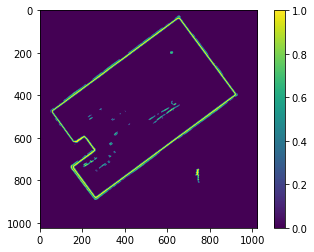

In [143]:
# Filters out some of the background murk
thresh = cv2.threshold(sobel, np.max(sobel)/5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8) # data type change again is preferred by cv2 for this bit for whatever reason.
plt.imshow(thresh)
plt.colorbar()

In [144]:
def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    plt.axis('off')

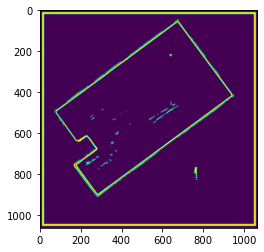

In [145]:
# puts a border around the edge which is meant to potentially help if want to tell if at edge or something. I think pads inside of border with 1 and then 0 inside that.
# if run multiple times will get concentric frames
thresh = np.pad(thresh,[(10,10),(10,10)],constant_values=1)
thresh = np.pad(thresh,[(10,10),(10,10)])
plt.imshow(thresh)

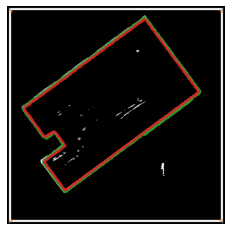

In [146]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

big_cnt = []
for c in contours:
    area = cv2.contourArea(c)
    perim = cv2.arcLength(c,True)
    if area > 3000 :#or perim > 2000:
        big_cnt.append(c)
        
plot_contours(big_cnt,thresh)

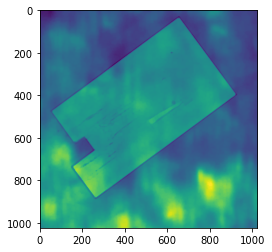

perims [4172.0, 4097.656854152679, 3356.236120581627, 2735.2613954544067]
areas [1087849.0, 1050623.0, 352225.0, 335726.0]
0 is max area index


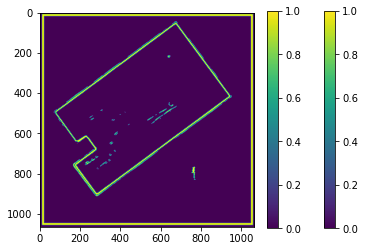

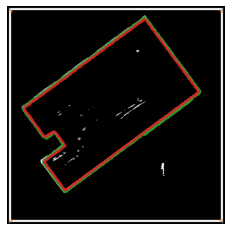

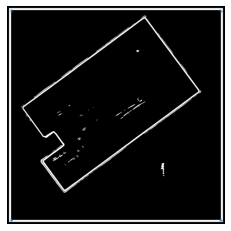

In [179]:
im = images[0]

# I thinik this is setting the size of a kernel
k_blur = 9 
k_open = 9
k_sobel=15

# Blur image
blurred = cv2.GaussianBlur(im, (k_blur, k_blur), 0)

# Open image
kernel = np.ones((k_open,k_open),np.uint8)
opening = cv2.morphologyEx(blurred,cv2.MORPH_OPEN,kernel)

plt.imshow(opening)
plt.show()

# Sobel filter
# Basically finds strong gradients going both ways for each pixel and adds them to come up with a sort of approximate
# Isn't quite contours yet but is making what should be contours stand out.
sobelx = cv2.Sobel(opening,cv2.CV_64F,1,0,ksize=k_sobel)
sobely = cv2.Sobel(opening,cv2.CV_64F,0,1,ksize=k_sobel)
sobel = abs(sobelx) + abs(sobely)
sobel = sobel/np.max(sobel)
plt.imshow(sobel)
plt.colorbar()

# Filters out some of the background murk
thresh = cv2.threshold(sobel, np.max(sobel)/5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8) # data type change again is preferred by cv2 for this bit for whatever reason.
plt.imshow(thresh)
plt.colorbar()


# puts a border around the edge which is meant to potentially help if want to tell if at edge or something. I think pads inside of border with 1 and then 0 inside that.
# if run multiple times will get concentric frames
thresh = np.pad(thresh,[(10,10),(10,10)],constant_values=1)
thresh = np.pad(thresh,[(10,10),(10,10)])
plt.imshow(thresh)

def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    plt.axis('off')



contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

big_cnt = []
areas = []
perims =[]
for c in contours:
    area = cv2.contourArea(c)
    perim = cv2.arcLength(c,True)
    if area > 3000 :#or perim > 2000:
        big_cnt.append(c)
        areas.append(area)
        perims.append(perim)

print("perims", perims)
print("areas", areas)
biggest_area = np.argmax(areas)
print(biggest_area, "is max area index")
plot_contours(big_cnt,thresh)
plot_contours(np.array([big_cnt[1]]),thresh)

#print(hierarchy)

# ok the very biggest is the frame and just appears as 4 dots in the corners.
# not sure how areas worked out
# will have to deal with this later I reckon - check his other example notebook?
# I checked area by finding area before it impinges on the edge. Seems to give a similar result to before so perhaps is doing about right and filling in. 
# Will have to play around with this later though as currently something funny happens when it reaches the edge. Need to detect this and work out what happens, seems contours get split

# look at im 0, 40, 60
# 60 shows same contours to me but with very different areas. Perhaps because impingement? 40 has difference too but is before impinge and is more minor.
# perims show bigger difference.
#seems hit or miss if shows padding twice in contours.